In [0]:
# questions I have as I think about this more:
# when we do the whole deduplication, we should only be doing that on TRAIN, right?

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from scipy.sparse import hstack, vstack
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

In [0]:
splits = "splits_1571429760//"

In [0]:
data_folder = "data//"
train_path = data_folder + splits + "train.csv"
dev_path = data_folder + splits + "dev.csv"

In [0]:
pkl_filename = "models//redo_first_model.pkl"
vectorizer_filename = "models//redo_first_vectorizer.pkl"

In [3]:
project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}

train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)

Updated property [core/project].


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
vectorizer = HashingVectorizer()

In [5]:
responses = train_df.response_text
xs = []

# we have to do this in chunks because fit_transform
# can't handle the whole thing in memory in string form
for i in range(1,11):
    print("starting chunk {}".format(i))
    chunk = responses.iloc[(i-1)*1000000:i*1000000]
    X = vectorizer.fit_transform(chunk.apply(lambda x: np.str_(x)))
    xs.append(X)

starting chunk 1
starting chunk 2
starting chunk 3
starting chunk 4
starting chunk 5
starting chunk 6
starting chunk 7
starting chunk 8
starting chunk 9
starting chunk 10


In [0]:
# this is how we recombine the chunks 
X = vstack(xs)

In [7]:
X.shape

(9879016, 1048576)

In [0]:
Y = train_df.op_gender.values

In [0]:
model = LogisticRegression(random_state=0)

In [10]:
time_start = time.time()


model.fit(X,Y)
currentTime = time.gmtime(time.time() - time_start)

#Convert the gmtime struct to a string
timeStr = time.strftime("%M minutes, %S seconds", currentTime)

print("Model trained in {}".format(timeStr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model trained in 40 minutes, 23 seconds


In [0]:
dev_x = vectorizer.fit_transform(dev_df.response_text.apply(lambda x: np.str_(x)))

In [0]:
dev_y = dev_df.op_gender.values

In [15]:
model.score(dev_x, dev_y)

0.8241332945470532

In [0]:
preds = model.predict(dev_x)

In [0]:
probs = model.predict_proba(dev_x)

In [22]:
def turn_to_ints(li):
    final_list = []
    for gender in li:
        if gender=='M':
            final_list.append(0)
        else:
            final_list.append(1)
    female = sum(final_list)
    male = len(final_list)-sum(final_list)
    percent_M = male/len(final_list)
    print('M: {}, W: {}, percent M: {}'.format(male,female,percent_M))
    return final_list

y_dev_gender = turn_to_ints(dev_df.op_gender.values)

M: 1948371, W: 344536, percent M: 0.8497383452534272


In [30]:
preds[:5]

array(['M', 'M', 'M', 'M', 'M'], dtype=object)

Proportion of predictions for W class: 0.06249184986569451
gender ROC_AUC: 0.6348007811159653


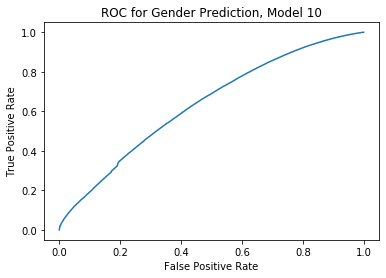

gender precision: 0.29513287923622356
gender recall: 0.12274189054264285
gender precision-recall AUC: 0.23636795087047519


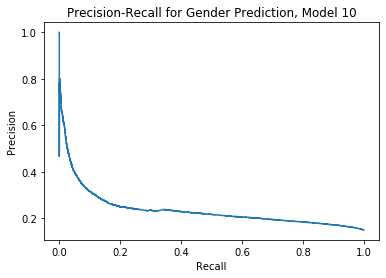

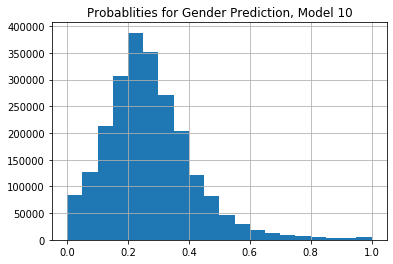

In [32]:
dev_df['probs'] = [prob[1] for prob in probs]
dev_df['preds'] = preds
preds = dev_df['probs'].values

if 'W' in dev_df.preds.value_counts():
  proportion_women_predicted = dev_df.preds.value_counts()['W'] / len(dev_df)
else:
  proportion_women_predicted = 0
print("Proportion of predictions for W class: {}".format(proportion_women_predicted))

#ROC-AUC
fpr,tpr,thresholds = roc_curve(y_dev_gender,preds)
print("gender ROC_AUC:",roc_auc_score(y_dev_gender,preds))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gender Prediction, Model {}'.format(i))
plt.show()

# precision-recall
print("gender precision:",precision_score(y_dev_gender,preds.round()))
print("gender recall:",recall_score(y_dev_gender,preds.round()))
precision, recall, thresholds = precision_recall_curve(y_dev_gender,preds)
print("gender precision-recall AUC:",auc(recall,precision))
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall for Gender Prediction, Model {}'.format(i))
plt.show()

# Plot probabilities.
plt.figure()
plt.title('Probablities for Gender Prediction, Model {}'.format(i))
dev_df.probs.hist(bins=20)
plt.show()